<a href="https://colab.research.google.com/github/umbertogagl97/FAdA/blob/main/examples/ScannerAttack.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Init**

##Import ART

In [ ]:
#importa ART
!pip install adversarial-robustness-toolbox

     |████████████████████████████████| 1.2 MB 4.6 MB/s 
     |████████████████████████████████| 3.3 MB 57.7 MB/s 
     |████████████████████████████████| 34.5 MB 12 kB/s 
  Attempting uninstall: llvmlite
    Found existing installation: llvmlite 0.34.0
    Uninstalling llvmlite-0.34.0:
      Successfully uninstalled llvmlite-0.34.0
  Attempting uninstall: numba
    Found existing installation: numba 0.51.2
    Uninstalling numba-0.51.2:
      Successfully uninstalled numba-0.51.2


##Import libraries

In [ ]:
import torch
import numpy as np
import torch.optim as optim
import torchvision
from torchvision import datasets, models, transforms

##Import FAdA

In [ ]:
!pip install git+https://github.com/umbertogagl97/FAda.git

  Cloning https://github.com/umbertogagl97/FAda.git to /tmp/pip-req-build-hs8m17p_
  Running command git clone -q https://github.com/umbertogagl97/FAda.git /tmp/pip-req-build-hs8m17p_
  Created wheel for FAdA: filename=FAdA-0.1.0-py3-none-any.whl size=37196 sha256=bc2733b9fb9e5399d833bc15765f119e6eb7ba2ba180ab573eec36899a0ac7db
  Stored in directory: /tmp/pip-ephem-wheel-cache-6gufpq_e/wheels/0f/e8/87/68d696ec0963ed3c7e5481376d2704842d11819c275439675e
Successfully built FAdA


In [ ]:
from fada.utils import *

##Check device


In [ ]:
print(torch.__version__)
if torch.cuda.is_available():
  print(torch.cuda.get_device_name(0))
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('device:',device)

1.10.0+cu111
Tesla T4
device: cuda:0


##Def path

In [ ]:
#scanner
scanner_name = 'GreenBit'

#load modello
path_model = F"/content/gdrive/My Drive/Scanner/{scanner_name}" 

#dataset
pathTestset=F'/content/gdrive/MyDrive/Dataset_impronte/test/{scanner_name}'

#predizioni testset originale
pd_preds=F'/content/gdrive/MyDrive/Dataset_impronte/test/Preds_value/{scanner_name}'

##Link google drive

In [ ]:
#collegamento google drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


#**Dataset**

##Load dataset

In [ ]:
test_dataset = datasets.ImageFolder(pathTestset,transform=transf_load)
dim_set=len(test_dataset)
print(dim_set)

2500


##Dataloader

In [ ]:
testgen=torch.utils.data.DataLoader(test_dataset, pin_memory=True, batch_size=1,num_workers=2)

##Classes name

In [ ]:
classes_name=test_dataset.classes
class_number=len(classes_name)
print(classes_name)
print(class_number)
#del test_dataset

['Live', 'Spoof']
2


##Min Max dataset

In [ ]:
_min,_max=0,1

##Transf_init

In [ ]:
a,_=next(iter(testgen))
size_init=np.array(a.shape[2:4])
transf_init=transforms.Resize(size=(size_init[0],size_init[1]),interpolation=InterpolationMode.NEAREST)

#**Dataset reduction**

In [ ]:
if scanner_name=='CrossMatch':
  test_dataset.samples=test_dataset.samples[1500:]
else: test_dataset.samples=test_dataset.samples[1000:]

dim_set=len(test_dataset)
print(dim_set)

1500


In [ ]:
material='Latex'
test_dataset.samples=[test_dataset.samples[i] for i in range(len(test_dataset)) if material in test_dataset.samples[i][0]]

dim_set=len(test_dataset)
print(dim_set)

250


execute if you want use few images

In [ ]:
n=2

test_dataset.samples=test_dataset.samples[:n]

dim_set=len(test_dataset)
print(dim_set)

2


# **Model**



##Load model pre-trained

In [ ]:
if scanner_name=='DigitalPersona':
  model = models.densenet201(pretrained=True,progress=True)
else: model = models.vgg19(pretrained=True,progress=True)

#print(model)

##Classifier

In [ ]:
if scanner_name=='DigitalPersona':
  model.classifier=nn.Linear(1920,2) #per densenet201
else: model.classifier[6]=nn.Linear(4096,2) #per vgg19


#print(model) 

##Load weights

In [ ]:
if device.type=='cpu': model.load_state_dict(torch.load(path_model,map_location=torch.device('cpu')))
else: model.load_state_dict(torch.load(path_model))

# **Execution**

##Classifier ART Pytorch



In [ ]:
from art.estimators.classification import PyTorchClassifier

if scanner_name=='DigitalPersona': lr=1e-4
else: lr=1e-5

classifier = PyTorchClassifier(
    model=model,
    clip_values=(_min,_max),
    loss=nn.CrossEntropyLoss(),
    optimizer=optim.Adam(model.classifier.parameters(),lr),
    input_shape=(3, 224, 224),
    nb_classes=class_number
)

##Attack

Attack version: 5

Elem: 1/2
img iniziale


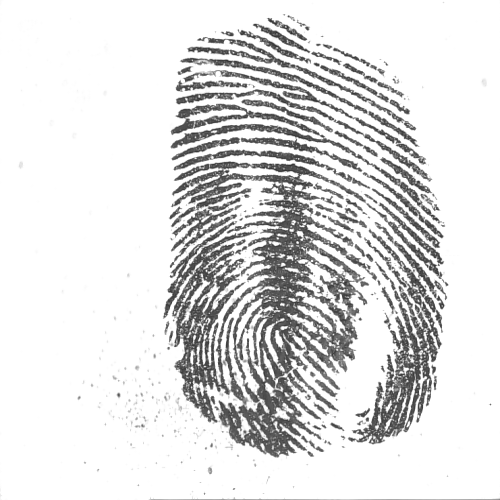

prob:  [5.155509e-08 1.000000e+00]
maschera


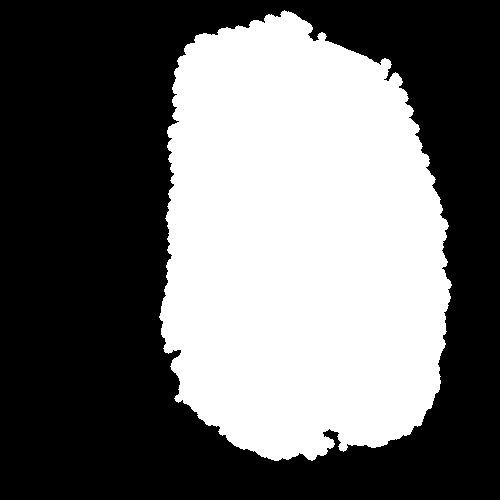

enhancement


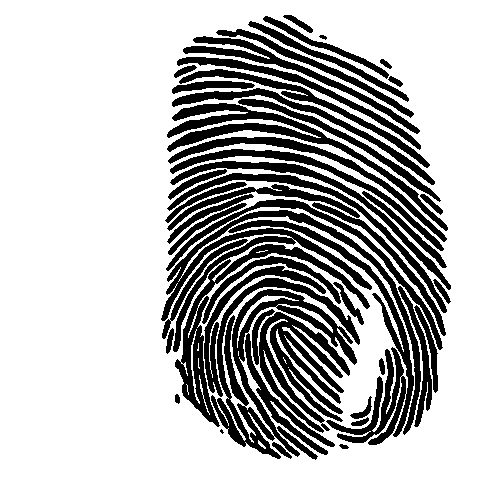

prob:  [0.00109017 0.99890983]
prob noise:  [4.9937316e-06 9.9999499e-01]
img iterazione: 1


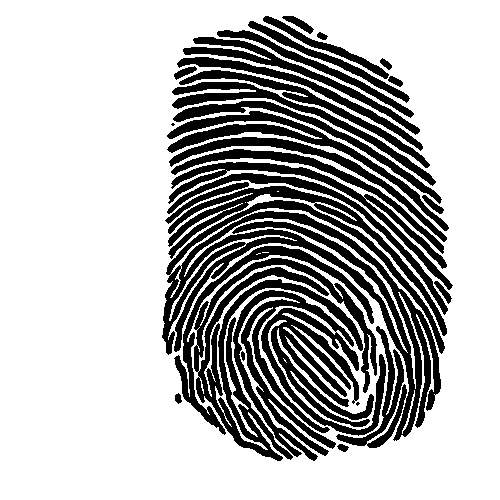

prob:  [0.5730174  0.42698258]
prob noise:  [5.4221673e-06 9.9999464e-01]
img iterazione: 2


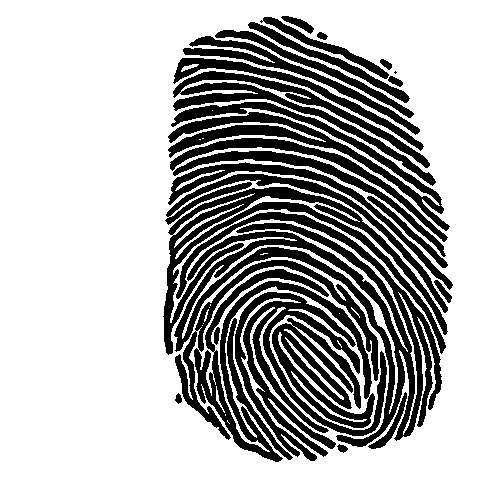

prob:  [0.9678968  0.03210315]
prob noise:  [8.574058e-04 9.991425e-01]
img iterazione: 3


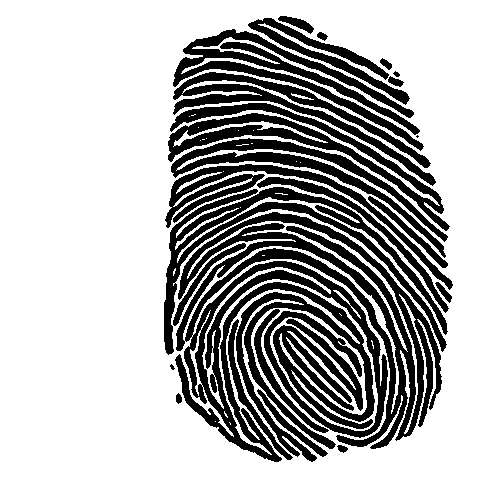

prob:  [9.9971634e-01 2.8365775e-04]
prob noise:  [0.00382909 0.99617094]


KeyboardInterrupt: ignored

In [ ]:
from fada.attacks.IFGM import IterativeFastGradientMethod
from fada.attacks.DeepFoolMultiOver import DeepFool_mod
from fada.attacks.AutoPGD_Mod import AutoProjectedGradientDescent_mod
from art.utils import to_categorical
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
import random
import time

#optional flags
save_img_print=True       #save images for suplot
show_img_progress=True   #show images during attack
save_img_adv=False        #save adv images on Drive

path_save_adv='/content/gdrive/MyDrive/prova/'
dir_adv='img_adv'
#attack version
v=5

#parameters
dilat=False
v_n=False
conf_n=0
probabilities_n=[0,0]
conf_in=0.8
iter=5
if v==3: rand_m=True
else: rand_m=False
target=classes_name.index('Live') #0 live, 1 spoof
jmax=5
confidence_loop=0.8
if (v==4 or v==5):
  element = ball(1)
  dilat=True
if v==5: 
  am=0.3
  v_n=True
  conf_n=0.65

# list attacks
attack = AutoProjectedGradientDescent_mod(classifier,eps=0.5,eps_step=0.3,nb_random_init=2,max_iter=iter,class_target=target,confidence=conf_in,verbose=False,random_mask=rand_m) 
#attack = IterativeFastGradientMethod(estimator=classifier, eps=10000,eps_step=0.0005,class_target=target,max_iter=iter,confidence=conf_in,random_mask=rand_m) 
#attack = DeepFool_mod(classifier, epsilon=0.1,max_iter=iter,nb_grads=2,class_target=target,confidence=conf_in,max_over=10,verbose=False,random_mask=rand_m)

if save_img_print:
  x_print=[]
  y_print=[]
  x_print_adv=[] 
  y_print_adv=[] 
  perturb_print=[]

Test_p = pd.DataFrame()

# starting time
start = time.time()

i=0
print("Attack version: "+str(v)+'\n')
for input,label in testgen:
  i+=1
  sys.stdout.write("\rElem: {0}/{1}".format(i,len(testgen)))
  sys.stdout.flush()

  y_test=np.array((to_categorical(label.numpy(),2)))
  x_test=np.array(input.numpy())
  
  pred,probabilities,_=test_average(classifier,torch.Tensor(x_test),transf_init)
  if show_img_progress:
    print('\nimg iniziale')
    cv2_imshow(x_test[0].transpose(1,2,0)*255)
    print('prob: ',probabilities)
  if label==1 and pred==1: #only if predict spoof
    filename=test_dataset.samples[i-1][0].split('Spoof/')[1]
    #compute mask
    m=compute_mask(torch.Tensor(x_test),dim_contours=8,n_rect=1) #for latex_greenbit use dim_contours=8,n_rect=1
    #enhancement
    if v==1: x_test_p=x_test.copy()
    else:  
      x_test_p=enhanc(x_test,m)
      if dilat: x_test_p[0]=erosion(x_test_p[0], element)
      if v_n==True:     
        noise=(random_noise(np.ones([500,500]), mode='pepper',amount=am))+np.random.random([500,500])
        noise=np.where(m==0,1,noise)
        x_n=(x_test_p*noise)#.type(torch.float)
        x_n=np.clip(x_n,0,1)
        _,probabilities_n,_=test_average(classifier,torch.Tensor(x_n),transf_init)
      pred,probabilities,_=test_average(classifier,torch.Tensor(x_test_p),transf_init)
    
    if show_img_progress:
      print('mask')
      cv2_imshow(m*255)
      if v!=1:
        print('enhancement')
        cv2_imshow(x_test_p[0].transpose(1,2,0)*255)
        print('prob: ',probabilities)
        if v_n: print('prob noise: ',probabilities_n)
    
    #resize mask for attack
    m_at = cv2.resize(m, (224,224),interpolation=cv2.INTER_NEAREST)
    
    j=0
    while (j<jmax and (probabilities[0]<confidence_loop or probabilities_n[0]<conf_n)):
      j+=1
      
      #attack
      x_test_adv=attack.generate(mask_mod=m_at, x=x_test_p, y=y_test, enh=False)

      #enhancement
      x_test_adv=enhanc(x_test_adv,m,[size_init[0],size_init[1]])
      if dilat: x_test_adv[0]=erosion(x_test_adv[0], element)
      if v_n==True:     
        noise=(random_noise(np.ones([500,500]), mode='pepper',amount=am))+np.random.random([500,500])
        noise=np.where(m==0,1,noise)
        x_n=(x_test_p*noise)#.type(torch.float)
        x_n=np.clip(x_n,0,1)
        _,probabilities_n,_=test_average(classifier,torch.Tensor(x_n),transf_init)

      if show_img_progress:
        print('img iteration: '+str(j))
        cv2_imshow(x_test_adv[0].transpose(1,2,0)*255)
      
      #test
      x_test_p=x_test_adv.copy()
      x_test_adv=torch.Tensor(x_test_adv)
      pred,probabilities,_=test_average(classifier,x_test_adv,transf_init)
      if show_img_progress:
        print('prob: ',probabilities)
        if v_n: print('prob noise: ',probabilities_n)

    if save_img_adv: #salva solo immagini che diventano Live
      if pred==0:
        cv2.imwrite(path_save_adv+dir_adv+'/'+filename,x_test_adv[0].numpy().transpose(1,2,0)*255)

    Test_p = Test_p.append({'name': filename,
                            'predicted': classes_name[pred], #qui metti pred
                            'real': classes_name[int(label)] ,
                            'liveness': round(probabilities[0]*100,4),},ignore_index = True)
    
    if save_img_print:
      #salva tutte le immagini
      perturb=compute_perturb(x_test[0],x_test_adv[0],transf_init)
      x_print.append(x_test[0])
      x_print_adv.append(x_test_adv[0].numpy())
      y_print.append(y_test)
      y_print_adv.append(probabilities)
      perturb_print.append(perturb)

if save_img_print:
  x_print=np.array(x_print)
  y_print=np.array(y_print)
  x_print_adv=np.array(x_print_adv)
  y_print_adv=np.array(y_print_adv)
  perturb_print=np.array(perturb_print)

# end time
end = time.time()

# total time taken
import datetime
time_exe=int(end - start)
time_exe=datetime.timedelta(seconds=time_exe)

print(f"\nRuntime of the program is {time_exe}")

if save_img_adv:
  Test_p.to_excel(path_save_adv+"list_results.xlsx",index=False)

##Show info initial test set



###accuracy totale

In [ ]:
Test_orig=pd.read_excel(pd_preds)
print_acc(Test_orig) 


Accuracy: 95.56
Shape dataframe: (2500, 4)


###accuracy classe spoof

In [ ]:
accuracy_class('Spoof',Test_orig)

# imgSpoof: 1500
Numero di predizioni Spoof giuste: 1470
Accuracy : 98.0


###accuracy classe live

In [ ]:
accuracy_class('Live',Test_orig)

# imgLive: 1000
Numero di predizioni Live giuste: 919
Accuracy : 91.9


##Testing adv images

###accuracy spoof

In [ ]:
accuracy_class('Spoof',Test_p)

# imgSpoof: 2
Numero di predizioni Spoof giuste: 1
Accuracy : 50.0


###number img spoof predicted live whit prob >confidence_loop

In [ ]:
p=Test_p.loc[Test_p['real']=='Spoof']
p=p.loc[p['predicted']=='Live']
print("img spoof-live: "+str(p.count(0)[0]))
p=p.loc[p['liveness']>=confidence_loop]
print("img prob_live>"+str(int(confidence_loop*100))+"%: "+str(p.count(0)[0]))

img spoof-live: 1
img con prob_live>80%: 1


##Subplot


> use only whit reduced dataset and if save_img_print=True



In [ ]:
preds_orig=[]
for input,_ in testgen:
  preds_orig_i,_,_=test_average(classifier,input,transf_init)
  preds_orig.append(preds_orig_i)
preds_orig=np.array(preds_orig)
#preds_orig=preds_orig[list_print]
preds_orig=np.array([classes_name[i] for i in preds_orig])
print_subplot(perturb_print,x_print,y_print,preds_orig,x_print_adv,y_print_adv)

#**Optional**

##saving and reading image to compare predicted values ​​before and after


> execute only if save_img_print=True



In [ ]:
for i in range(len(x_print_adv)):  
  bef,aft=save_read(np.array(x_print_adv[i]),classifier,transf_init)
  print('img: ',i+1)
  print('before: {0} after: {1}'.format(bef,aft))

##Testing images from drive



In [ ]:
import os
Test_preds = pd.DataFrame()
path_images="/content/gdrive/MyDrive/..images directory../"
directory = os.listdir(path_images)
i=0
for input in directory:
  i+=1
  sys.stdout.write("\rElem: {0}/{1}".format(i,len(directory)))
  sys.stdout.flush()
  img=cv2.imread(path_images+input)
  img=(img-np.min(img))/(np.max(img)-np.min(img))
  pred,probabilities,_=test_average(classifier,torch.Tensor(img.transpose(2,0,1)).unsqueeze_(0),transf_init)
  Test_preds = Test_preds.append({'name': input,
                                  'predicted': classes_name[pred], #qui metti pred
                                  'prob_live': probabilities[0]*100,},ignore_index = True)

Elem: 1/1

In [ ]:
print(Test_preds)

                         name predicted  prob_live
0  GreenBit_Latex_004_0_0.png      Live  98.277575


save file excel

In [ ]:
Test_preds.to_excel("/content/gdrive/MyDrive/..directory../results.xlsx",index=False)

#**XAI**


> Study of image's heatmap



In [ ]:
!pip install captum

     |████████████████████████████████| 1.4 MB 7.9 MB/s 


In [ ]:
from captum.attr import Occlusion 
occlusion = Occlusion(model.eval())

In [ ]:
strides = (3, 8, 8)               # smaller = more fine-grained attribution but slower
target=0,                       # Live class
sliding_window_shapes=(3,45, 45)  # choose size enough to change object appearance
baselines = 0                     # values to occlude the image with. 0 corresponds to gray

In [ ]:
from captum.attr import visualization as viz

vis_types = ["blended_heat_map"]
vis_signs = ["all"] # "positive", "negative", or "all" to show both
# positive attribution indicates that the presence of the area increases the prediction score
# negative attribution indicates distractor areas whose absence increases the score


##single image from files

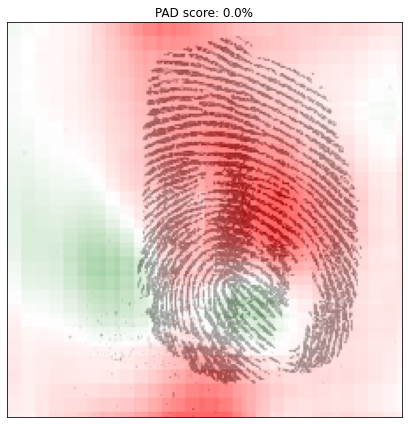

In [ ]:
img=cv2.imread('img.png')
img=(img-np.min(img))/(np.max(img)-np.min(img))
img=torch.Tensor(img.transpose(2,0,1)).unsqueeze_(0)
pred,probabilities,_=test_average(classifier,img,transf_init)
img=transf_resize(img)

input_img=data_transform_test(img)
input_img=input_img.to(device)

attribution_live = occlusion.attribute(input_img,
                                       strides = strides,
                                       target=target,
                                       sliding_window_shapes=sliding_window_shapes,
                                       baselines=baselines)

attribution_live = np.transpose(attribution_live.squeeze().cpu().detach().numpy(), (1,2,0))

p = viz.visualize_image_attr_multiple(attribution_live,
                                      np.array(img[0]).transpose(1,2,0),
                                      vis_types,
                                      vis_signs,
                                      [("PAD score: "+str(round(probabilities[0]*100,2))+'%')],
                                      alpha_overlay=0.6,
                                      show_colorbar = False
                                     )

save output

In [ ]:
p[0].savefig('xai_img.png')

#**Noise Study**


> Noisy perturbed image testing to predict behavior after printing



In [ ]:
import os
from skimage.util import random_noise

img=cv2.imread('img_adv.png')
img=(img-np.min(img))/(np.max(img)-np.min(img))
img=torch.Tensor(img.transpose(2,0,1)).unsqueeze_(0)
    
m=compute_mask(img,dim_contours=8,n_rect=1)
n=(random_noise(np.ones([500,500]), mode='pepper',amount=0.3))+np.random.random([500,500])
n=np.where(m==0,1,n)
img=(img*n).type(torch.float)
img=np.clip(img,0,1)
cv2_imshow(np.array(img[0]).transpose(1,2,0)*255)
print(pred,probabilities,_=test_average(classifier,img,transf_init))